In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cust_df = pd.read_csv('./Data/SantanderData.csv')
cust_df.columns

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)

In [35]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [36]:
cust_df['TARGET'].value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

In [37]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=20, bootstrap=True, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:747: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:753: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


0.9609477769008156

In [40]:
y_pred2 = bag_clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred2)

0.9583004472507235

In [41]:
bag_clf.oob_decision_function_

array([[0.99419361, 0.00580639],
       [0.99379407, 0.00620593],
       [0.93949618, 0.06050382],
       ...,
       [0.98327944, 0.01672056],
       [0.95586588, 0.04413412],
       [0.94713708, 0.05286292]])

In [44]:
feature_importances = np.mean([tree.feature_importances_ for tree in bag_clf.estimators_], axis=0)

feature_importances[:10]

array([0.00134505, 0.46211923, 0.00064479, 0.        , 0.        ,
       0.        , 0.        , 0.0027147 , 0.00883597, 0.        ])

In [45]:
import seaborn as sns

imp_values = feature_importances
imp_values = pd.Series(imp_values, index=X_train.columns)
imp_values20 = imp_values.sort_values(ascending=False)[:20]
imp_values20

var15                      0.462119
saldo_var30                0.319035
var38                      0.091171
saldo_var25                0.009420
imp_op_var41_efect_ult3    0.009142
imp_op_var40_efect_ult3    0.008836
saldo_medio_var5_hace3     0.008576
ind_var26_cte              0.007096
imp_op_var41_efect_ult1    0.006959
imp_sal_var16_ult1         0.005661
ind_var8_0                 0.005290
imp_op_var39_efect_ult1    0.004632
num_var22_ult3             0.004357
num_var45_hace3            0.003821
saldo_medio_var8_hace2     0.003416
saldo_var5                 0.003039
imp_op_var40_efect_ult1    0.002715
num_var45_hace2            0.002626
num_var37_0                0.002339
saldo_medio_var8_ult3      0.002330
dtype: float64

<AxesSubplot:title={'center':'Feature Importance Top 20'}>

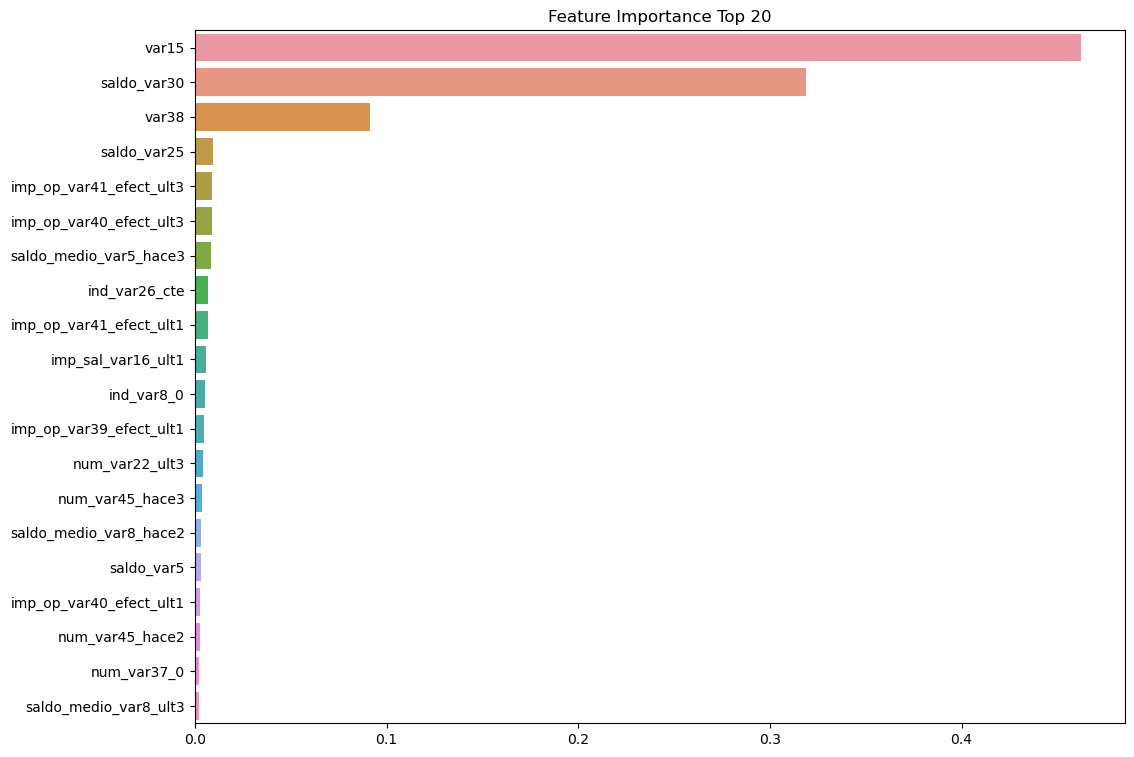

In [47]:
plt.figure( figsize = (12, 9) )
plt.title('Feature Importance Top 20')
sns.barplot(x=imp_values20, y=imp_values20.index)

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5,
                                min_samples_leaf=8, min_samples_split=8,
                                random_state=8, oob_score=True)

rf_clf.fit(X_train, y_train)
y_pred3 = rf_clf.predict(X_test)

In [49]:
accuracy_score(y_test, y_pred3)

0.9583004472507235

In [51]:
rf_clf.oob_score_

0.9609642199421204

In [52]:
rf_clf.oob_decision_function_

array([[0.97428755, 0.02571245],
       [0.98349969, 0.01650031],
       [0.97698955, 0.02301045],
       ...,
       [0.90431373, 0.09568627],
       [0.97560965, 0.02439035],
       [0.97710625, 0.02289375]])

<AxesSubplot:title={'center':'Feature Importance Top 20'}>

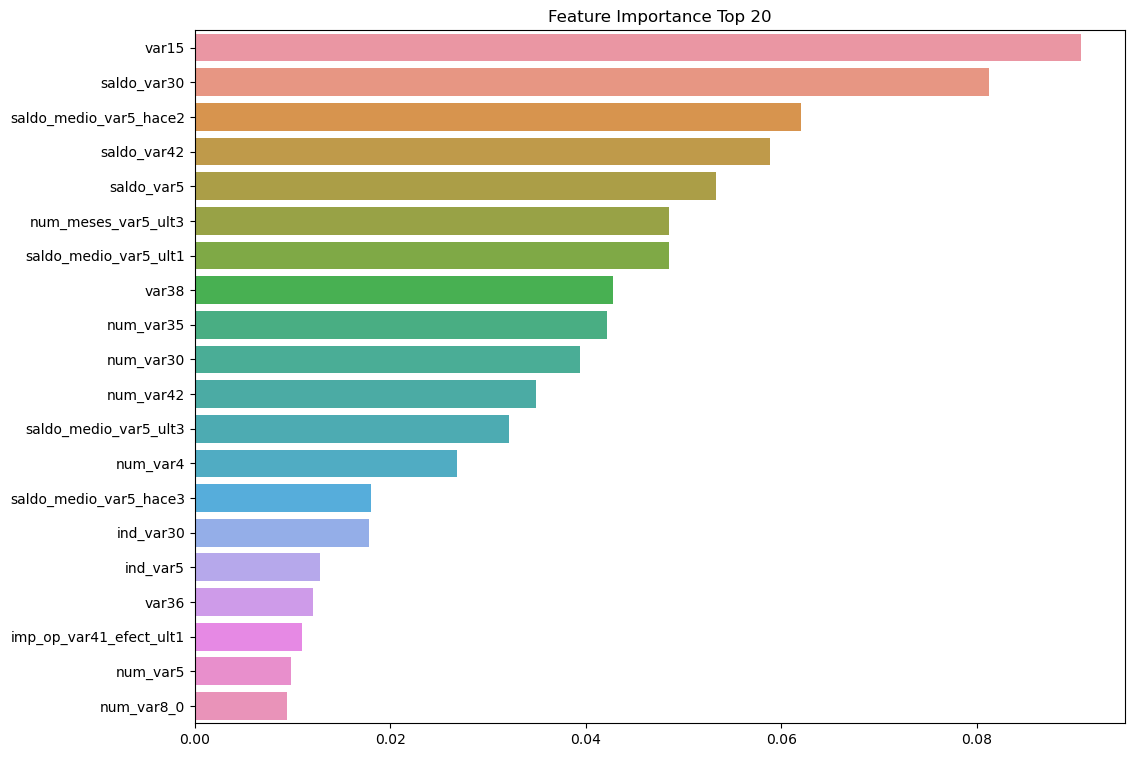

In [54]:
imp_values2 = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
imp_values2_20 = imp_values2.sort_values(ascending=False)[:20]
plt.figure(figsize=(12, 9))
plt.title('Feature Importance Top 20')
sns.barplot(x=imp_values2_20, y=imp_values2_20.index)

In [55]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=100, random_state=1,
                             algorithm='SAMME.R')

ada_clf.fit(X_train, y_train)
y_pred4 = rf_clf.predict(X_test)
accuracy_score(y_test, y_pred4)


0.9583004472507235

In [56]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=123)

In [57]:
errors = [accuracy_score(y_val, y_valpred) for y_valpred in ada_clf.staged_predict(X_val)]

bst_n_estimators= np.argmin(errors)
bst_n_estimators

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


34

Text(0, 0.5, 'Accuracy')

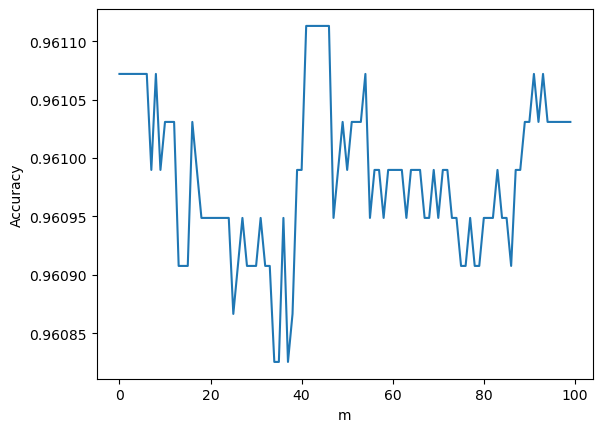

In [59]:
plt.plot(errors)
plt.xlabel('m')
plt.ylabel('Accuracy')

In [ ]:
ada_clf.oob_score_

In [ ]:
ada_clf.oob_decision_function_

In [60]:
ada_clf_best = AdaBoostClassifier(random_state=0, n_estimators=bst_n_estimators)

ada_clf_best.fit(X_train, y_train)
y_pred5 = ada_clf_best.predict(X_test)
accuracy_score(y_test, y_pred5)

0.9582346750855039